In [14]:
import pickle
import random
import argparse
import numpy as np
from rdkit import Chem
import rdkit.Chem.QED
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import torch
from torch.utils.data import DataLoader
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.regression.basic_due import basic_due
from coati.data.dataset import ecloud_dataset
from coati.common.util import batch_indexable
from coati.math_tools.altair_plots import roc_plot
from coati.generative.coati_purifications import force_decode_valid_batch, purify_vector, embed_smiles
from coati.generative.embed_altair import embed_altair
from coati.utils.chem import read_sdf
import os.path as osp
from glob import glob
from tqdm import tqdm
import os
import shutil
def write_sdf(mols, filename):
    w = Chem.SDWriter(filename)
    for mol in mols:
        w.write(mol)
    w.close()
from rdkit.Chem import AllChem
def gen_geom_with_rdkit(mol):
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol)
        mol = Chem.RemoveHs(mol)
    except:
        pass
    return mol

In [4]:
arg_parser = argparse.ArgumentParser()
arg_parser.add_argument('--mode', choices=['basic', 'near', 'regression', 'dynamics'], \
    default='basic',help='Generation mode')
arg_parser.add_argument('--device', choices=['cuda:0', 'cpu'], \
    default='cuda:0',help='Device')
arg_parser.add_argument('--seed', type=int, default=2024) 
arg_parser.add_argument('--model', type=str, default = 'model_ckpts/ecloud_augmented_37.pkl')
arg_parser.add_argument('--dataset', type=str, default='data/ecloud_coati_demo.pt')
arg_parser.add_argument('--output', type=str, default='0423_near_mol4_30.txt')
arg_parser.add_argument('--noise', type=float, default=0.6)
args = arg_parser.parse_args([])

In [5]:
DEVICE = args.device
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url=args.model,
)

Loading model from model_ckpts/ecloud_augmented_37.pkl
Loading tokenizer mar from model_ckpts/ecloud_augmented_37.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 19.60M Total: 22.04M 
Freezing encoder
44882816 params frozen!


In [4]:
# generate molecules form generated eclouds
gen_base = './generation/ecloud_gens_32/'
save_base = './generation/ecloudgen_mols_32_gen_full/'
targets = glob(osp.join(gen_base, '*'))
for target in tqdm(targets):
    ref_ecloud = glob(osp.join(target, '*_ecloudref.npy'))[0]
    gen_ecloud = glob(osp.join(target, '*_ecouldgen.npy'))[0]
    pdb_file = glob(osp.join(target, '*.pdb'))[0]
    ori_sdf = glob(osp.join(target, '*.sdf'))[0]

    cloud_npy = gen_ecloud
    eclouds = torch.Tensor(np.load(cloud_npy)).to(torch.float).to(DEVICE)
    smiles_list = encoder.decipher_eclouds_to_mols(eclouds, tokenizer, '[SMILES]', noise_scale=args.noise, batch_repeat=5, total_gen=1000)
    mols_list = [Chem.MolFromSmiles(s) for s in smiles_list]
    mols_list = [gen_geom_with_rdkit(m) for m in mols_list]
    save_dir = osp.join(save_base, osp.basename(target))
    SDF_dir = osp.join(save_dir, 'SDF')
    os.makedirs(SDF_dir, exist_ok=True)
    write_sdf(mols_list, osp.join(save_dir, f'{osp.basename(target)}_ecloudgen.sdf'))
    for i, m in enumerate(mols_list):
        write_sdf([m], osp.join(SDF_dir, f'{i}.sdf'))
    shutil.copy(pdb_file, save_dir)
    # shutil.copy(ref_ecloud, save_dir)
    # shutil.copy(gen_ecloud, save_dir)
    shutil.copy(ori_sdf, save_dir)

100%|██████████| 100/100 [24:39<00:00, 14.79s/it]


In [5]:
# generate molecules form generated eclouds
gen_base = './generation/ecloud_gens_32/'
save_base = './generation/ecloudgen_mols_32_ref_more/'
targets = glob(osp.join(gen_base, '*'))
for target in tqdm(targets):
    ref_ecloud = glob(osp.join(target, '*_ecloudref.npy'))[0]
    gen_ecloud = glob(osp.join(target, '*_ecouldgen.npy'))[0]
    pdb_file = glob(osp.join(target, '*.pdb'))[0]
    ori_sdf = glob(osp.join(target, '*.sdf'))[0]

    cloud_npy = ref_ecloud
    eclouds = torch.Tensor(np.load(cloud_npy)).to(torch.float).to(DEVICE)
    smiles_list = encoder.decipher_eclouds_to_mols(eclouds, tokenizer, '[SMILES]', noise_scale=args.noise, batch_repeat=50, total_gen=500)
    mols_list = [Chem.MolFromSmiles(s) for s in smiles_list]
    mols_list = [gen_geom_with_rdkit(m) for m in mols_list]
    save_dir = osp.join(save_base, osp.basename(target))
    SDF_dir = osp.join(save_dir, 'SDF')
    os.makedirs(SDF_dir, exist_ok=True)
    write_sdf(mols_list, osp.join(save_dir, f'{osp.basename(target)}_ecloudgen.sdf'))
    for i, m in enumerate(mols_list):
        write_sdf([m], osp.join(SDF_dir, f'{i}.sdf'))
    shutil.copy(pdb_file, save_dir)
    # shutil.copy(ref_ecloud, save_dir)
    # shutil.copy(gen_ecloud, save_dir)
    shutil.copy(ori_sdf, save_dir)

100%|██████████| 100/100 [26:24<00:00, 15.84s/it]


In [4]:
# generate molecules form generated eclouds
gen_base = './generation/resgen_epo57_top10/'
save_base = './generation/resgen_epo57_top10/'
targets = glob(osp.join(gen_base, '*'))
for target in tqdm(targets):
    gen_ecloud = glob(osp.join(target, '*.npy'))[0]

    cloud_npy = gen_ecloud
    eclouds = torch.Tensor(np.load(cloud_npy)).to(torch.float).to(DEVICE)
    smiles_list = encoder.decipher_eclouds_to_mols(eclouds, tokenizer, '[SMILES]', noise_scale=args.noise, batch_repeat=25, total_gen=200)
    mols_list = [Chem.MolFromSmiles(s) for s in smiles_list]
    mols_list = [gen_geom_with_rdkit(m) for m in mols_list]
    save_dir = osp.join(save_base, osp.basename(target))
    SDF_dir = osp.join(save_dir, 'SDF')
    os.makedirs(SDF_dir, exist_ok=True)
    write_sdf(mols_list, osp.join(save_dir, f'{osp.basename(target)}_ecloudgen.sdf'))
    for i, m in enumerate(mols_list):
        write_sdf([m], osp.join(SDF_dir, f'{i}.sdf'))


100%|██████████| 73/73 [23:48<00:00, 19.56s/it]


In [7]:
gen_base = './generation/resgen_epo57_top10/'
save_base = './generation/resgen_epo57_top10/'
targets = glob(osp.join(gen_base, '*'))
for target in tqdm(targets):
    ori_sdf = max(glob(osp.join(target, '*.sdf')), key=len)
    ori_dir = osp.join(target, 'ori')
    os.makedirs(ori_dir, exist_ok=True)
    shutil.copy(ori_sdf, osp.join(ori_dir, '0.sdf'))

100%|██████████| 73/73 [00:00<00:00, 3992.28it/s]


In [6]:
ori_sdf

'./generation/resgen_epo57_top10/3w83_B_rec_2e6d/3w83_B_rec_2e6d_fum_lig_tt_min_0.sdf'

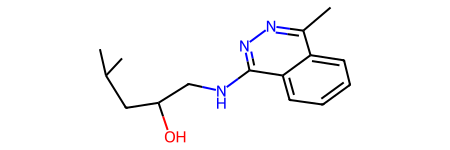

In [32]:
mols_list[100]

In [12]:
# generate from single ecloud
ori_mol = read_sdf('./examples/BRD4/KRD4.sdf')[0]
cloud_npy = './examples/BRD4/KRD4_ecloud.npy'
eclouds = torch.Tensor(np.load(cloud_npy)).to(torch.float).to(DEVICE)
smiles_list = encoder.decipher_eclouds_to_mols(eclouds, tokenizer, '[SMILES]', noise_scale=args.noise, batch_repeat=5, total_gen=1000)
mols_list = [Chem.MolFromSmiles(s) for s in smiles_list]
mols_list = [gen_geom_with_rdkit(m) for m in mols_list]
write_sdf(mols_list, './generation/BRD4/KRD4_from_ecloud.sdf')

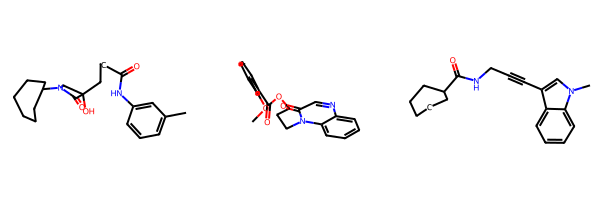

In [21]:
from rdkit import Chem
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols_list[:3])

In [33]:
ori_mol = read_sdf('./examples/BRD4/KRD4.sdf')[0]
ori_smi = Chem.MolToSmiles(ori_mol)
cloud_npy = './examples/BRD4/KRD4_ecloud.npy'
s = Chem.MolToSmiles(Chem.MolFromSmiles(ori_smi))
raw_token = tokenizer.tokenize_text("[SMILES]" + s + "[STOP]", pad=True)
raw_token = torch.Tensor(raw_token).to(DEVICE).unsqueeze(0)
eclouds = torch.Tensor(np.load(cloud_npy)).to(torch.float).to(DEVICE).unsqueeze(0)

In [46]:
noise_scales = [0.1, 0.3, 0.6, 0.9]
for noise_scale in noise_scales:
    num_to_gen = 200
    smiles_near_ref = encoder.ecloud_and_token_to_2d_batch(
    eclouds = eclouds,
    tokens = raw_token.long(),
    tokenizer = tokenizer,
    num_to_gen = num_to_gen, 
    noise_scale = noise_scale,
    )
    mols_list = [Chem.MolFromSmiles(s) for s in smiles_near_ref]
    mols_list = [m for m in mols_list if m is not None]
    mols_list = [gen_geom_with_rdkit(m) for m in mols_list]
    write_sdf(mols_list, f'./generation/BRD4/KRD4_from_smiecloud_{noise_scale}.sdf')